# Document Clustering and Topic Modeling

In this project, we use unsupervised learning models to cluster unlabeled documents into different groups, visualize the results and identify their latent topics/structures.

## Contents

<ul>
<li>[Part 1: Load Data](#Part-1:-Load-Data)
<li>[Part 2: Tokenizing and Stemming](#Part-2:-Tokenizing-and-Stemming)
<li>[Part 3: TF-IDF](#Part-3:-TF-IDF)
<li>[Part 4: K-means clustering](#Part-4:-K-means-clustering)
<li>[Part 5: Topic Modeling - Latent Dirichlet Allocation](#Part-5:-Topic-Modeling---Latent-Dirichlet-Allocation)
</ul>

# Part 1: Load Data

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import nltk
import re
import os

from sklearn import decomposition
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import lda

Read data from files. In summary, we have 100 titles and 100 synoposes (combined from imdb and wiki).

In [3]:
#import three lists: titles and wikipedia synopses
titles = open('./data/title_list.txt').read().split('\n')
titles = titles[:100] #ensures that only the first 100 are read in

#The wiki synopses and imdb synopses of each movie is seperated by the keywords "BREAKS HERE". 
#Each synoposes may consist of multiple paragraphs.
synopses_wiki = open('./data/synopses_list_wiki.txt').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_imdb = open('./data/synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

#Combine imdb and wiki to get full synoposes for the top 100 movies. 
synopses = []
for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)
    
#Because these synopses have already been ordered in popularity order, 
#we just need to generate a list of ordered numbers for future usage.
ranks = range(len(titles))

# Part 2: Tokenizing and Stemming

Load stopwords and stemmer function from NLTK library.
Stop words are words like "a", "the", or "in" which don't convey significant meaning.
Stemming is the process of breaking a word down into its root.

In [138]:
stopwords = nltk.corpus.stopwords.words('english')
len(stopwords)

179

In [139]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append('n\'t')
print ("We use " + str(len(stopwords)) + " stop-words from nltk library.")
print (stopwords[:10])

We use 180 stop-words from nltk library.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [140]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenization_and_stemming(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
#     tokens=[]
#     for sent in nltk.sent_tokenize(text):
#         for word in nltk.word_tokenize(sent):
#             if word not in stopwords:
#                 tokens.append(word);   
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenization(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [141]:
stemmer.stem('movie')

'movi'

In [142]:
tokenization_and_stemming("she looked at her father's arm.")

['look', 'father', "'s", 'arm']

Use our defined functions to analyze (i.e. tokenize, stem) our synoposes.

In [143]:
docs_stemmed = []
docs_tokenized = []
for i in synopses:
    tokenized_and_stemmed_results = tokenization_and_stemming(i)
    docs_stemmed.extend(tokenized_and_stemmed_results)
    
    tokenized_results = tokenization(i)
    docs_tokenized.extend(tokenized_results)

In [144]:
print(len(docs_stemmed), len(docs_tokenized))

184262 184262


Create a mapping from stemmed words to original tokenized words for result interpretation.

In [145]:
vocab_frame_dict = {docs_stemmed[x]:docs_tokenized[x] for x in range(len(docs_stemmed))}
print (vocab_frame_dict['angel'])

angeles


In [ ]:
vocab_frame_dict

# Part 3: TF-IDF

In [165]:
#define vectorizer parameters
tfidf_model = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.1, stop_words='english',
                                 use_idf=True, tokenizer=tokenization_and_stemming, ngram_range=(1,2))

tfidf_matrix = tfidf_model.fit_transform(synopses) #fit the vectorizer to synopses

print ("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " synoposes and " + str(tfidf_matrix.shape[1]) + " terms.")

In total, there are 100 synoposes and 1290 terms.


In [166]:
tfidf_matrix

<100x1290 sparse matrix of type '<class 'numpy.float64'>'
	with 29271 stored elements in Compressed Sparse Row format>

In [167]:
tfidf_model.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 0.8,
 'max_features': 200000,
 'min_df': 0.1,
 'ngram_range': (1, 2),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': 'english',
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': <function __main__.tokenization_and_stemming>,
 'use_idf': True,
 'vocabulary': None}

In [168]:
tfidf_matrix.todense()

matrix([[ 0.00727567,  0.00863072,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.03944489,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 0.0049127 ,  0.        ,  0.04079365, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.00881673,  0.0104588 ,  0.        , ...,  0.        ,
          0.02367489,  0.        ],
        [ 0.15097527,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]])

Save the terms identified by TF-IDF.

In [169]:
tf_selected_words = tfidf_model.get_feature_names()
tf_selected_words

["'d",
 "'m",
 "'s apart",
 "'s bodi",
 "'s death",
 "'s face",
 "'s father",
 "'s friend",
 "'s home",
 "'s hous",
 "'s life",
 "'s mother",
 "'s offic",
 "'s plan",
 "'s sister",
 "'s voic",
 "'s wife",
 'abandon',
 'abil',
 'abl',
 'aboard',
 'abus',
 'accept',
 'accid',
 'accident',
 'accompani',
 'accord',
 'accus',
 'acquaint',
 'act',
 'action',
 'activ',
 'actual',
 'adam',
 'addit',
 'address',
 'admir',
 'admit',
 'advanc',
 'advantag',
 'advic',
 'advis',
 'affair',
 'afraid',
 'afternoon',
 'afterward',
 'age',
 'agent',
 'ago',
 'agre',
 'ahead',
 'aid',
 'aim',
 'air',
 'airport',
 'al',
 'alcohol',
 'aliv',
 'allow',
 'alon',
 'alreadi',
 'alway',
 'ambush',
 'america',
 'american',
 'angel',
 'anger',
 'angri',
 'angrili',
 'anim',
 'announc',
 'annoy',
 'anoth',
 'anoth man',
 'answer',
 'anymor',
 'anyon',
 'anyth',
 'apart',
 'apart build',
 'apolog',
 'appar',
 'appear',
 'approach',
 'area',
 'argu',
 'argument',
 'arm',
 'armi',
 'arrang',
 'arrest',
 'arriv',
 'a

In [177]:
len(tf_selected_words)

1290

# (Optional) Calculate Document Similarity

In [94]:
from sklearn.metrics.pairwise import cosine_similarity
cos_matrix = cosine_similarity(tfidf_matrix)
print (cos_matrix)

[[ 1.          0.1996283   0.23342595 ...,  0.3581728   0.3277855
   0.17714484]
 [ 0.1996283   1.          0.26626879 ...,  0.26910321  0.22856581
   0.10870124]
 [ 0.23342595  0.26626879  1.         ...,  0.27738654  0.24669308
   0.12805055]
 ..., 
 [ 0.3581728   0.26910321  0.27738654 ...,  1.          0.55040973
   0.08151334]
 [ 0.3277855   0.22856581  0.24669308 ...,  0.55040973  1.          0.13005234]
 [ 0.17714484  0.10870124  0.12805055 ...,  0.08151334  0.13005234  1.        ]]


In [95]:
cos_matrix.shape

(100, 100)

# Part 4: K-means clustering

In [41]:
from sklearn.cluster import KMeans

num_clusters = 5
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

In [42]:
set(clusters)

{0, 1, 2, 3, 4}

## 4.1. Analyze K-means Result

In [43]:
# create DataFrame films from all of the input files.
films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters}
frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster'])

In [44]:
frame.head(10)

,rank,title,cluster
4,0,The Godfather,4
4,1,The Shawshank Redemption,4
2,2,Schindler's List,2
4,3,Raging Bull,4
4,4,Casablanca,4
3,5,One Flew Over the Cuckoo's Nest,3
2,6,Gone with the Wind,2
4,7,Citizen Kane,4
3,8,The Wizard of Oz,3
3,9,Titanic,3


In [47]:
print ("Number of films included in each cluster:")
frame['cluster'].value_counts().to_frame()

Number of films included in each cluster:


,cluster
2,29
3,27
4,20
1,18
0,6


In [19]:
grouped = frame['rank'].groupby(frame['cluster'])
print "Average rank (1 to 100) per cluster:"
grouped.mean().to_frame()

Average rank (1 to 100) per cluster:


,rank
cluster,
0,55.800000
1,39.714286
2,48.181818
3,47.600000
4,54.852941


In [58]:
km.cluster_centers_

array([[ 0.00086182,  0.00284298,  0.        , ...,  0.01150295,
         0.05738499,  0.00303946],
       [ 0.01108122,  0.01521101,  0.01226587, ...,  0.02574462,
         0.06086044,  0.02702202],
       [ 0.00342677,  0.02131127,  0.01075405, ...,  0.01793775,
         0.00143768,  0.01872953],
       [ 0.01652311,  0.00421957,  0.01767342, ...,  0.02917622,
         0.01973936,  0.03547731],
       [ 0.01233097,  0.01325542,  0.01053114, ...,  0.05369774,
         0.04801907,  0.02708964]])

In [102]:
print ("<Document clustering result by K-means>")

#km.cluster_centers_ denotes the importances of each items in centroid.
#We need to sort it in decreasing-order and get the top k items.
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

Cluster_keywords_summary = {}
for i in range(num_clusters):
    print ("Cluster " + str(i) + " words:" ,)
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        Cluster_keywords_summary[i].append(vocab_frame_dict[tf_selected_words[ind]])
        print (vocab_frame_dict[tf_selected_words[ind]] + ",",)
    print ()
    #Here ix means index, which is the clusterID of each item.
    #Without tolist, the values result from dataframe is <type 'numpy.ndarray'>
    cluster_movies = frame.ix[i]['title'].values.tolist()
    print ("Cluster " + str(i) + " titles (" + str(len(cluster_movies)) + " movies): " )
    print (", ".join(cluster_movies))
    print ()

<Document clustering result by K-means>
Cluster 0 words:
george,
marries,
family,
woman,
friend,
john,

Cluster 0 titles (6 movies): 
It's a Wonderful Life, The Philadelphia Story, An American in Paris, The King's Speech, A Place in the Sun, Tootsie

Cluster 1 words:
car,
apartment,
police,
asks,
killing,
n't,

Cluster 1 titles (18 movies): 
Psycho, Sunset Blvd., West Side Story, Rocky, The Apartment, The French Connection, Midnight Cowboy, Annie Hall, Fargo, Shane, The Graduate, American Graffiti, Pulp Fiction, The Maltese Falcon, Taxi Driver, Rear Window, The Third Man, North by Northwest

Cluster 2 words:
army,
killing,
soldiers,
war,
commanded,
men,

Cluster 2 titles (29 movies): 
Schindler's List, Gone with the Wind, Lawrence of Arabia, Star Wars, The Bridge on the River Kwai, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Apocalypse Now, The Lord of the Rings: The Return of the King, Gladiator, From Here to Eternity, Saving Private Ryan, Unforgiven, Raiders

## 4.2. Plot K-means Result

In [103]:
pca = decomposition.PCA(n_components=2)
tfidf_matrix_np=tfidf_matrix.toarray()
pca.fit(tfidf_matrix_np)
X = pca.transform(tfidf_matrix_np)

xs, ys = X[:, 0], X[:, 1]

#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
#set up cluster names using a dict
cluster_names = {}
for i in range(num_clusters):
    cluster_names[i] = ", ".join(Cluster_keywords_summary[i])

In [105]:
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 
groups = df.groupby(clusters)
groups.head()

,label,title,x,y
0,4,The Godfather,-0.016222,0.038313
1,4,The Shawshank Redemption,0.029739,-0.068316
2,2,Schindler's List,0.273559,0.042563
3,4,Raging Bull,-0.079710,0.113530
4,4,Casablanca,0.103797,-0.084927
5,3,One Flew Over the Cuckoo's Nest,0.038220,-0.097799
6,2,Gone with the Wind,0.062255,0.086516
7,4,Citizen Kane,-0.156293,0.139448
8,3,The Wizard of Oz,-0.002374,-0.087030
9,3,Titanic,-0.030640,-0.035000


In [107]:
for name, group in groups:
    print(name, group)

0     label                   title         x         y
26      0   It's a Wonderful Life -0.127735  0.607679
41      0  The Philadelphia Story -0.119970  0.420451
43      0    An American in Paris -0.179822  0.258661
65      0       The King's Speech -0.067711  0.493929
67      0      A Place in the Sun -0.133982  0.603822
75      0                 Tootsie -0.232525  0.264736
1     label                  title         x         y
12      1                 Psycho -0.233186 -0.265216
13      1           Sunset Blvd. -0.215526 -0.075181
18      1        West Side Story -0.098213 -0.087025
39      1                  Rocky -0.148439 -0.070649
54      1          The Apartment -0.181872 -0.034458
63      1  The French Connection -0.173590 -0.323152
68      1        Midnight Cowboy -0.224591  0.052980
71      1             Annie Hall -0.217967  0.133038
76      1                  Fargo -0.241550 -0.352161
79      1                  Shane  0.126005 -0.116491
84      1           The Graduate -0

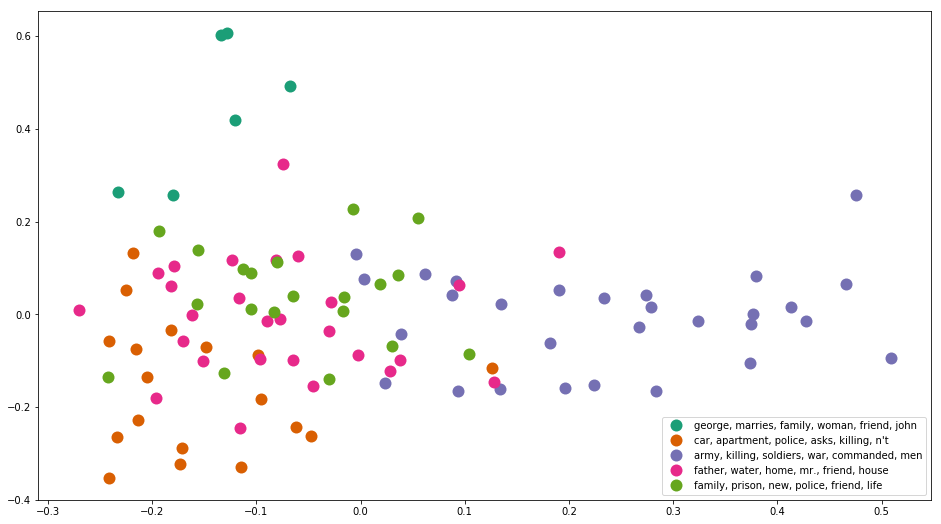

In [106]:
%matplotlib inline 

#create data frame with PCA cluster results
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 
groups = df.groupby(clusters)

# set up plot
fig, ax = plt.subplots(figsize=(16, 9))
#Set color for each cluster/group
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')

ax.legend(numpoints=1,loc=4)  #show legend with only 1 point, position is right bottom.

plt.show() #show the plot

In [23]:
plt.close()

# Part 5: Topic Modeling - Latent Dirichlet Allocation

In [170]:
#Now we use synopses to build a 100*551 matrix (terms)
#map words to index
terms_dict = {tf_selected_words[x]:x for x in range(len(tf_selected_words))}

feature_matrix_synopses_tf = []
for i in synopses:
    current_doc_stats = [0] * len(tf_selected_words)
    allwords_stemmed = tokenization_and_stemming(i)
    for get_terms in allwords_stemmed:
        if get_terms in tf_selected_words:
            current_doc_stats[terms_dict[get_terms]] += 1
    current_doc_stats = np.asarray(current_doc_stats)
    feature_matrix_synopses_tf.append(current_doc_stats)
    
feature_matrix_synopses_tf = np.asarray(feature_matrix_synopses_tf)

In [203]:
# use tfidf_matrix matrix as input to lda
feature_matrix_synopses_tf = np.round(np.array(tfidf_matrix.todense())*100).astype(np.int)

In [198]:
model = lda.LDA(n_topics=5, n_iter=500, random_state=1)

<li> "model.topic_word_" saves the importance of tf_selected_words in LDA model, i.e. words similarity matrix
<li> The shape of "model.topic_word_" is (n_topics,num_of_selected_words)
<li> "model.doc_topic_" saves the document topic results, i.e. document topic matrix.
<li> The shape of "model.doc_topic_" is (num_of_documents, n_topics)

In [201]:
model.fit(feature_matrix_synopses_tf)
topic_word = model.topic_word_  # model.components_ also works
n_top_words = 7

topic_keywords_list = []
for i, topic_dist in enumerate(topic_word):
    #Here we select top(n_top_words-1)
    lda_topic_words = np.array(tf_selected_words)[np.argsort(topic_dist)][:-n_top_words:-1] 
    for j in range(len(lda_topic_words)):
        lda_topic_words[j] = vocab_frame_dict[lda_topic_words[j]]
    topic_keywords_list.append(lda_topic_words.tolist())

INFO:lda:n_documents: 100
INFO:lda:vocab_size: 1290
INFO:lda:n_words: 111351
INFO:lda:n_topics: 5
INFO:lda:n_iter: 500
INFO:lda:<0> log likelihood: -989202
INFO:lda:<10> log likelihood: -852549
INFO:lda:<20> log likelihood: -830409
INFO:lda:<30> log likelihood: -822689
INFO:lda:<40> log likelihood: -817768
INFO:lda:<50> log likelihood: -815425
INFO:lda:<60> log likelihood: -814022
INFO:lda:<70> log likelihood: -812981
INFO:lda:<80> log likelihood: -812209
INFO:lda:<90> log likelihood: -810862
INFO:lda:<100> log likelihood: -810218
INFO:lda:<110> log likelihood: -809929
INFO:lda:<120> log likelihood: -809909
INFO:lda:<130> log likelihood: -809761
INFO:lda:<140> log likelihood: -809765
INFO:lda:<150> log likelihood: -809620
INFO:lda:<160> log likelihood: -809389
INFO:lda:<170> log likelihood: -809430
INFO:lda:<180> log likelihood: -808665
INFO:lda:<190> log likelihood: -809172
INFO:lda:<200> log likelihood: -808761
INFO:lda:<210> log likelihood: -808831
INFO:lda:<220> log likelihood: -80

In [202]:
doc_topic = model.doc_topic_
topic_doc_dict = {}

print ("<Document clustering result by LDA>")
for i in range(len(doc_topic)):
    topicID = doc_topic[i].argmax()
    if topicID not in topic_doc_dict:
        topic_doc_dict[topicID] = [titles[i]]
    else:
        topic_doc_dict[topicID].append(titles[i])
for i in topic_doc_dict:
    print ("Cluster " + str(i) + " words: " + ", ".join(topic_keywords_list[i]))
    print ("Cluster " + str(i) + " titles (" + str(len(topic_doc_dict[i])) + " movies): ") 
    print (', '.join(topic_doc_dict[i]))
    print ()

<Document clustering result by LDA>
Cluster 1 words: michael, killing, fight, police, train, town
Cluster 1 titles (20 movies): 
The Godfather, Titanic, The Godfather: Part II, On the Waterfront, West Side Story, The Silence of the Lambs, Chinatown, 12 Angry Men, Gladiator, From Here to Eternity, Unforgiven, Butch Cassidy and the Sundance Kid, High Noon, Rain Man, Tootsie, Shane, The Maltese Falcon, Double Indemnity, Rebel Without a Cause, The Third Man

Cluster 4 words: german, army, soldiers, war, captain, water
Cluster 4 titles (23 movies): 
The Shawshank Redemption, Schindler's List, Casablanca, The Wizard of Oz, Lawrence of Arabia, Star Wars, The Bridge on the River Kwai, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Apocalypse Now, The Lord of the Rings: The Return of the King, Saving Private Ryan, Raiders of the Lost Ark, Patton, Jaws, The Treasure of the Sierra Madre, Platoon, Dances with Wolves, The Pianist, The Deer Hunter, All Quiet on the Western Fro

# Appendix: K-means

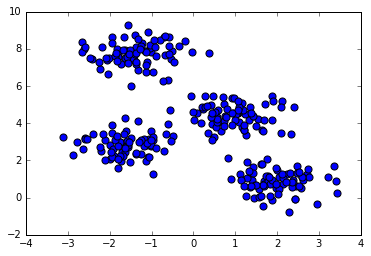

In [28]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], s=50);

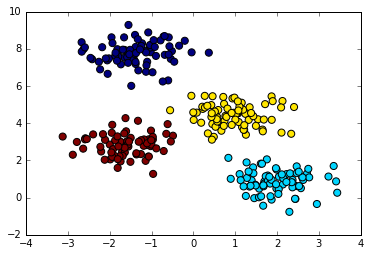

In [29]:
from sklearn.cluster import KMeans
est = KMeans(4)  # 4 clusters
est.fit(X)
y_kmeans = est.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50);